# Predicting the noise level of noisy fashionmnist images

## Imports

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.fid import *

In [ ]:
set_seed(1103, False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
from diffusers import UNet2DModel, DDPMPipeline, DDIMPipeline, DDPMScheduler, DDIMScheduler

In [ ]:
from fastprogress import progress_bar

## Load dataset

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

In [ ]:
torch.linspace(0.001, 0.999, 10)

tensor([0.0010, 0.1119, 0.2228, 0.3337, 0.4446, 0.5554, 0.6663, 0.7772, 0.8881,
        0.9990])

In [ ]:
torch.linspace(0.001, 0.999, 10).logit()

tensor([-6.9068, -2.0716, -1.2496, -0.6916, -0.2227,  0.2227,  0.6916,  1.2496,
         2.0716,  6.9068])

In [ ]:
def add_noise(x0):
    device = x0.device
    bs = x0.shape[0]

    t = torch.rand((bs, 1, 1, 1), device=device)
    noise = torch.randn(x0.shape, device=device)
    original_part = t.sqrt() * x0
    noise_part = (1 - t).sqrt() * noise
    xt = original_part + noise_part
    return xt, t.squeeze().logit()

In [ ]:
def get_collate_ddpm():
    def _collate_ddpm(b):
        return add_noise(default_collate(b)[fm_x])
    return _collate_ddpm

collate_ddpm = get_collate_ddpm()

In [ ]:
def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
@inplace
def transformi(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") - 0.5 for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 256
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))
xb, yb = next(iter(dls.train))

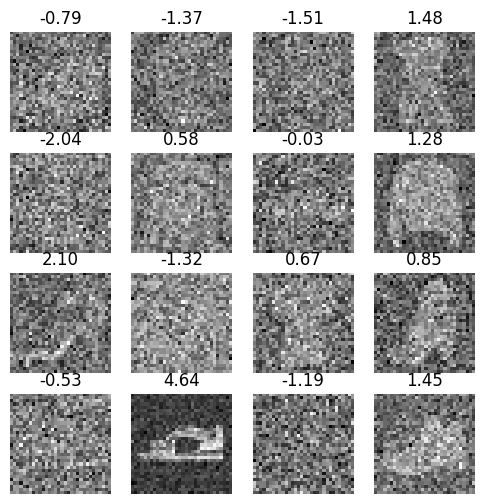

In [ ]:
show_images(xb[:16], imsize=1.5, titles=list(map(lambda t: f"{t:.2f}", yb[:16])))

In [ ]:
class Constant(nn.Module):
    def __init__(self, c=0):
        super().__init__()
        self.dummy = nn.Linear(1,1)
        self.c = c

    def forward(self, x):
        bs = x.shape[0]
        device = x.device
        return torch.full((bs,), self.c, device=device)

In [ ]:
learn = TrainLearner(Constant(), dls, F.mse_loss, cbs=[MetricsCB()])
learn.fit(1, train=False)

{'loss': '3.309', 'epoch': 0, 'train': 'valid'}


In [ ]:
def flat_mse(x, y):
    return F.mse_loss(x.flatten(), y.flatten())

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_drop=0.2):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *layers,
        nn.Flatten(), nn.Dropout(p_drop),
        nn.Linear(nfs[-1], 1)
    )
    return model

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

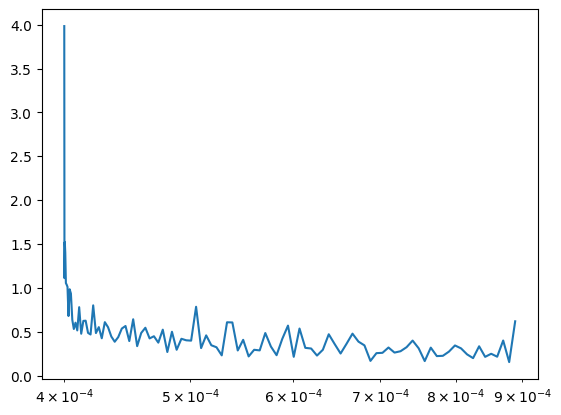

In [ ]:
epochs = 10
lr = 0.01
init_w = partial(init_weights, leak=0.1)
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
opt_func = partial(optim.AdamW, eps=1e-4)


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
TrainLearner(model, dls, flat_mse, lr=lr, cbs=[DeviceCB(), sched, augment], opt_func=opt_func).lr_find()

loss,epoch,train
0.668,0,train
0.491,0,valid
0.300,1,train
0.456,1,valid
0.232,2,train
0.190,2,valid
0.206,3,train
0.241,3,valid
0.186,4,train
0.209,4,valid


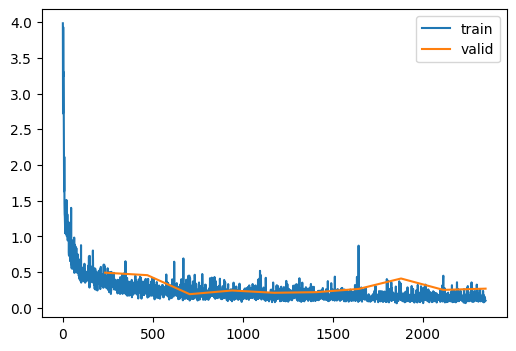

In [ ]:
epochs = 10
lr = 0.0008
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
cbs = [DeviceCB(), MetricsCB(), ProgressCB(plot=True), sched, augment]
opt_func = partial(optim.AdamW, eps=1e-4)


set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, flat_mse, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "22_noise-pred_10.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "22_noise-pred_10.pkl").cuda()

In [ ]:
with torch.no_grad():
    predicted_t = to_cpu(model(xb.cuda()))

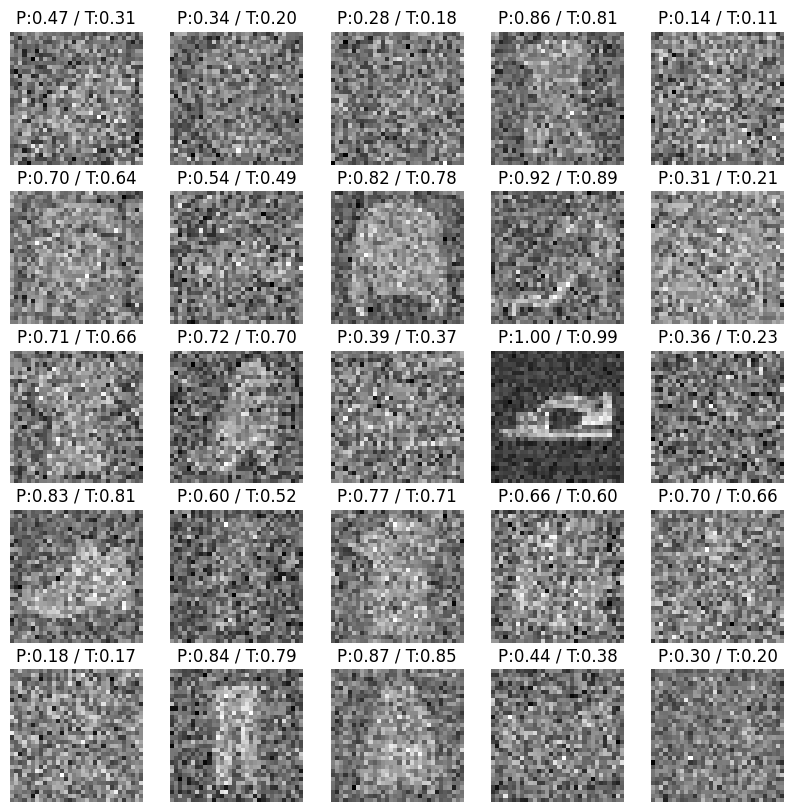

In [ ]:
c = 25
titles = [f"P:{predicted_t[i].sigmoid().item():.2f} / T:{yb[i].sigmoid():.2f}" for i in range(c)]
show_images(xb[:c], titles=titles, imsize=2);

## No-time model

In [ ]:
def abar(t):
    return (t * (math.pi / 2)).cos() ** 2

def inv_abar(x):
    return x.sqrt().acos() * (2 / math.pi)

In [ ]:
def add_noise(x0):
    device = x0.device
    bs = x0.shape[0]

    t = torch.rand((bs, 1, 1, 1), device=device)
    noise = torch.randn(x0.shape, device=device)
    original_part = t.sqrt() * x0
    noise_part = (1 - t).sqrt() * noise
    xt = original_part + noise_part
    return xt, noise

In [ ]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(x, 0).sample

In [ ]:
def init_ddpm(model):
    for down_block in model.down_blocks:
        for resnet in down_block.resnets:
            resnet.conv2.weight.data.zero_()
        downsamplers = down_block.downsamplers
        if not downsamplers: downsamplers = []
        for downsampler in downsamplers:
            init.orthogonal_(downsampler.conv.weight)

    model.conv_out.weight.data.zero_()

In [ ]:
bs = 128
dls = DataLoaders(dl_ddpm(dst["train"]), dl_ddpm(dst["test"]))

loss,epoch,train
0.318,0,train
0.035,0,valid
0.031,1,train
0.028,1,valid
0.028,2,train
0.026,2,valid
0.026,3,train
0.025,3,valid
0.025,4,train
0.024,4,valid


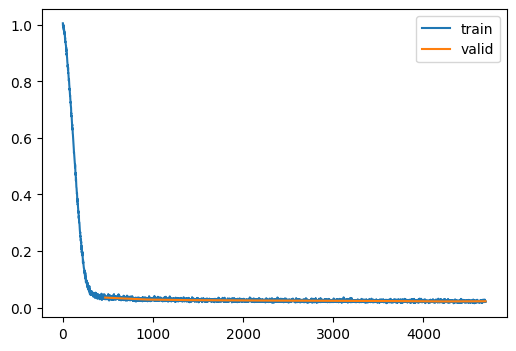

In [ ]:
set_seed(1103, False)
lr = 0.001
epochs = 10
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(), sched]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=16)
init_ddpm(model)

opt_func = partial(optim.AdamW, eps=1e-4)

learn = TrainLearner(model, dls, F.mse_loss, lr=lr, cbs=cbs, opt_func=opt_func)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "22_noise-pred_no_time_10.pkl")

In [ ]:
model_path = Path("models")
model = torch.load(model_path / "22_noise-pred_no_time_10.pkl").cuda()

## Sampling

In [ ]:
class Schedule:
    def __init__(self, alphas, betas, alphas_bar, sigmas, n_steps):
        fc.store_attr()

def linear_sched(beta_min=0.0001, beta_max=0.02, n_steps=1000):
    betas = torch.linspace(beta_min, beta_max, n_steps)
    alphas = 1 - betas
    alphas_bar = torch.cumprod(alphas, 0)
    sigmas = betas.sqrt()
    return Schedule(alphas, betas, alphas_bar, sigmas, n_steps)

schedule = linear_sched(beta_min=0.00001, beta_max=0.01)

In [ ]:
@inplace
def transformi2(b):
    b["image"] = [TF.pad(TF.to_tensor(i), padding=2, fill=0, padding_mode="constant") * 2 - 1 for i in b["image"]]
dst2 = ds.with_transform(transformi2)

bs2 = 256
dls2 = DataLoaders.from_dd(dst2, bs2)

fid_model = torch.load('models/14_aug_for_fid.pkl')
del fid_model[8]
del fid_model[7]

image_eval = ImageEval(fid_model, dls2, cbs=[DeviceCB()])

In [ ]:
xb, yb = next(iter(dls2.train))

In [ ]:
model_path = Path("models")
t_model = torch.load(model_path / "22_noise-pred_10.pkl").cuda()
model = torch.load(model_path / "22_noise-pred_no_time_10.pkl").cuda()

In [ ]:
set_seed(1103, False)

In [ ]:
def ddim_step(x_t, t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = (x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device) if t > 0 else 0
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
def sample(f, model, sz, n_steps, schedule=schedule, skips=1, eta=1.):
    ts = list(range(0, n_steps, skips))[::-1]
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for idx, t in enumerate(progress_bar(ts)):
            t_batch = torch.full((bs,), t, dtype=torch.int64, device=device)
            noise_pred = model(x)

            alpha_bar_t = schedule.alphas_bar[t]
            alpha_bar_t_minus_1 = schedule.alphas_bar[ts[idx + 1]] if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, t, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            process.append(to_cpu(x))
    return process

In [ ]:
%time generated = sample(ddim_step, model, (bs2, 1, 32, 32), 1000, skips=25)
final = generated[-1] * 2

CPU times: user 14.5 s, sys: 39.8 ms, total: 14.6 s
Wall time: 14.6 s


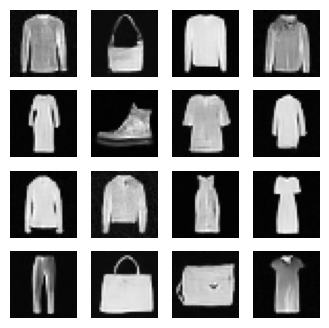

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(31.7200927734375, 0.08268022537231445)

In [ ]:
image_eval.fid(xb), image_eval.kid(xb)

(15.4024658203125, -0.006153106689453125)

In [ ]:
def ddim_step(x_t, t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = (x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device) if t > 0 else 0
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
def sample(f, model, sz, n_steps, schedule=schedule, skips=1, eta=1.):
    ts = list(range(0, n_steps, skips))[::-1]
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for idx, t in enumerate(progress_bar(ts)):
            # t_batch = torch.full((bs,), t, dtype=torch.int64, device=device)
            t_batch = (t_model(x).sigmoid() * 1000).ceil().int().reshape(-1)
            noise_pred = model(x)

            alpha_bar_t = schedule.alphas_bar[t]
            alpha_bar_t_minus_1 = schedule.alphas_bar[ts[idx + 1]] if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, t, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            process.append(to_cpu(x))
    return process

In [ ]:
%time generated = sample(ddim_step, model, (bs2, 1, 32, 32), 1000, skips=25)
final = generated[-1] * 2

CPU times: user 15.1 s, sys: 70.6 ms, total: 15.1 s
Wall time: 15.1 s


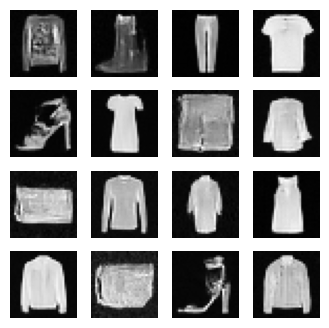

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(25.65283203125, 0.050835609436035156)

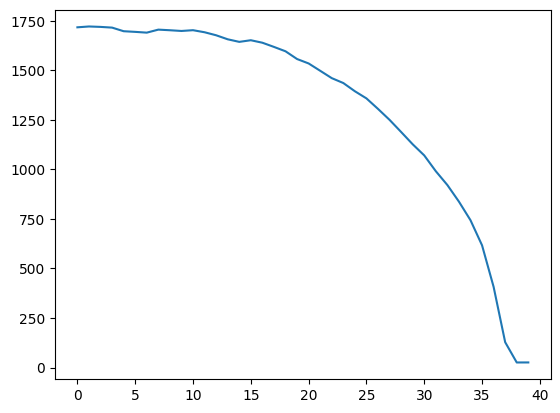

In [ ]:
plt.plot([image_eval.fid(g * 2) for g in generated]);

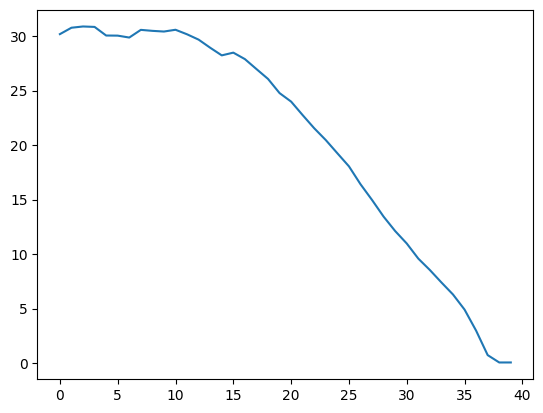

In [ ]:
plt.plot([image_eval.kid(g * 2) for g in generated]);

In [ ]:
als = to_cpu(t_model(xb.cuda()).sigmoid())

In [ ]:
als.min(), als.median(), als.mean(), als.max(), als.std()

(tensor(0.8911),
 tensor(0.9567),
 tensor(0.9548),
 tensor(0.9896),
 tensor(0.0187))

In [ ]:
def ddim_step(x_t, t, noise, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta, clipv=2):
    # Equation (12)
    predicted_coef = alpha_bar_t_minus_1.sqrt()
    predicted_x0 = ((x_t - beta_bar_t.sqrt() * noise) * (1 / alpha_bar_t.sqrt())).clip(-clipv, clipv)
    sigma_t = (beta_bar_t_minus_1 / beta_bar_t).sqrt() * (1 - alpha_bar_t / alpha_bar_t_minus_1).sqrt() * eta
    sigma_t[sigma_t.isnan()] = 0.
    noise_coef = beta_bar_t_minus_1 - sigma_t ** 2
    noise_coef[noise_coef < 1e-5] = beta_bar_t_minus_1
    direction_to_x_t = (beta_bar_t_minus_1 - sigma_t ** 2).sqrt() * noise
    random_noise = sigma_t * torch.randn(x_t.shape, device=x_t.device) if t > 0 else 0
    x_t_minus_1 = predicted_coef * predicted_x0 + direction_to_x_t + random_noise
    return x_t_minus_1

In [ ]:
def sample(f, model, sz, n_steps, schedule=schedule, skips=1, eta=1.):
    ts = list(range(0, n_steps, skips))[::-1]
    device = next(model.parameters()).device
    with torch.no_grad():
        x = torch.randn(sz, device=device)
        bs = x.shape[0]
        process = []

        for idx, t in enumerate(progress_bar(ts)):
            # t_batch = torch.full((bs,), t, dtype=torch.int64, device=device)
            alpha_bar_t = t_model(x).sigmoid().reshape(-1, 1, 1, 1)
            sd = alpha_bar_t.std()
            m = alpha_bar_t.mean()
            alpha_bar_t = alpha_bar_t.clamp(m - 2 * sd, m + 2 * sd)
            t_batch = (alpha_bar_t * 1000).ceil().int().reshape(-1)
            noise_pred = model(x)

            # alpha_bar_t = schedule.alphas_bar[t]
            alpha_bar_t_minus_1 = schedule.alphas_bar[ts[idx + 1]] if t > 0 else torch.tensor(1)
            beta_bar_t = 1 - alpha_bar_t
            beta_bar_t_minus_1 = 1 - alpha_bar_t_minus_1
            x = f(x, t, noise_pred, alpha_bar_t, alpha_bar_t_minus_1, beta_bar_t, beta_bar_t_minus_1, eta)

            process.append(to_cpu(x))
    return process

In [ ]:
generated = sample(ddim_step, model, (bs2, 1, 32, 32), 1000, skips=25)
final = generated[-1] * 2

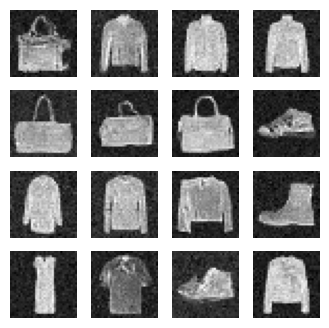

In [ ]:
show_images(final[:16], imsize=1);

In [ ]:
image_eval.fid(final), image_eval.kid(final)

(157.65966796875, 1.1356720924377441)

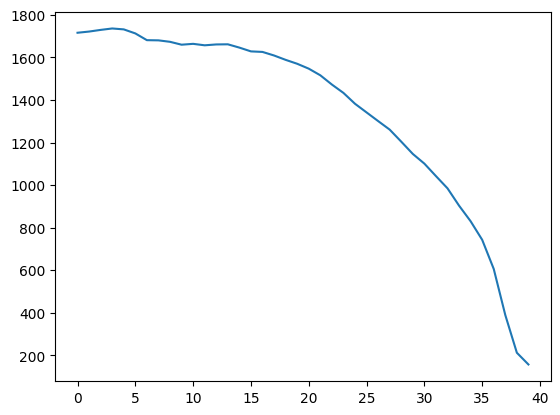

In [ ]:
plt.plot([image_eval.fid(g * 2) for g in generated]);

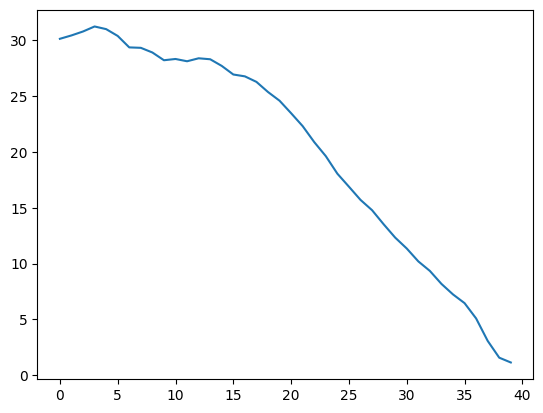

In [ ]:
plt.plot([image_eval.kid(g * 2) for g in generated]);